In [1]:
import os
import math
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from scipy.misc import imresize

warnings.simplefilter("ignore", category=DeprecationWarning)

%matplotlib inline
pd.set_option("display.max_rows", 10)
np.random.seed(42)

Using TensorFlow backend.


In [2]:
os.listdir("../input/")

['train.csv', 'test', 'sample_submission.csv', 'train']

In [3]:
dataset = pd.read_csv("../input/train.csv")
dataset.sample(5)

,Image,Id
20621,cfb8c68dc.jpg,new_whale
10152,66bf04895.jpg,w_b27b6c6
21324,d6a92a7f9.jpg,new_whale
16229,a37e5cc98.jpg,new_whale
4097,2a215f11e.jpg,new_whale


In [4]:
dataset.shape

(25361, 2)

In [5]:

counter = 0
train_X = np.zeros((1000, 100, 100, 3))
for image_name in dataset.iloc[:1000,0]:
    if counter % 100 == 0: print(f'Loaded {counter} images')
    image_data = mpimg.imread(f'../input/train/{image_name}')
    image_data = imresize(image_data, (100,100,3), interp='bilinear', mode=None)
    if len(image_data.shape) == 3:
        train_X[counter,:,:,:] = image_data
        counter += 1


Loaded 0 images
Loaded 100 images
Loaded 200 images
Loaded 300 images
Loaded 400 images
Loaded 500 images
Loaded 600 images
Loaded 700 images
Loaded 800 images


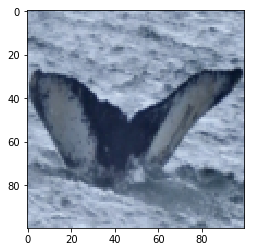

In [6]:
plt.imshow(train_X[1,:,:,:]/255)

In [7]:
model = Sequential()
model.add(Conv2D(filters=32, 
                 kernel_size=(10,10), 
                 activation='relu',
                 input_shape = (100, 100, 3)))
model.add(Conv2D(filters=64, 
                 activation='relu',
                 kernel_size=(5,5)))
model.add(MaxPool2D())
model.add(Dropout(.25))
model.add(Flatten())
model.add(Dense(1, activation='softmax'))
opt = Adam(lr=0.012, decay=0.001)
model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["categorical_accuracy"])
model.build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 91, 91, 32)        9632      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 43, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 118336)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 118337    
Total params: 179,233
Trainable params: 179,233
Non-trainable params: 0
_________________________________________________________________


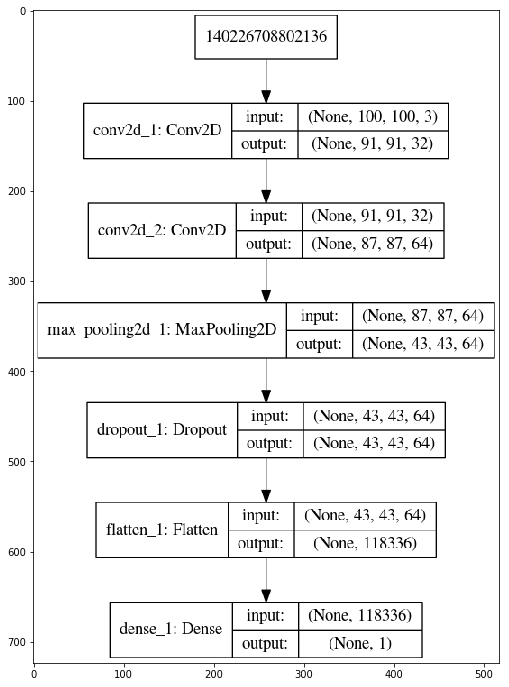

In [8]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(12,12))
plt.imshow(mpimg.imread('model.png'))